# Import libs

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm


import matplotlib.pyplot as plt  # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


torch.cuda.is_available()

True

In [2]:
print("System Version:", sys.version)
print("PyTorch version", torch.__version__)
print("Torchvision version", torchvision.__version__)
print("Numpy version", np.__version__)
print("Pandas version", pd.__version__)

System Version: 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
PyTorch version 2.1.2+cu121
Torchvision version 0.16.2+cpu
Numpy version 1.26.3
Pandas version 2.1.4


# Download dataset with Kaggle API

You need an API key to use the Kaggle API.  
Click on your profile picture (top right), go to Settings, Create New Token, then download & open the file.  
Copy the contents, and paste them in the following cell (e.g., creds = '{"username":"xxx","key":"xxx"}'):

In [3]:
# creds = '{"username":"YOUR_USERNAME","key":"YOUR_API_KEY"}'

Then execute this cell (this only needs to be run once) - thanks [Jeremy Howard](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)!

In [4]:
# for working with paths in Python, I recommend using `pathlib.Path`

# cred_path = Path("~/.kaggle/kaggle.json").expanduser()
# if not cred_path.exists():
#     cred_path.parent.mkdir(exist_ok=True)
#     cred_path.write_text(creds)
#     cred_path.chmod(0o600)



Run this next cell to download the dataset from Kaggle:


In [5]:
# !kaggle datasets download -d gpiosenka/cards-image-datasetclassification

The API command above can be obtained by clicking the three black dots and selecting `Copy API command`:   
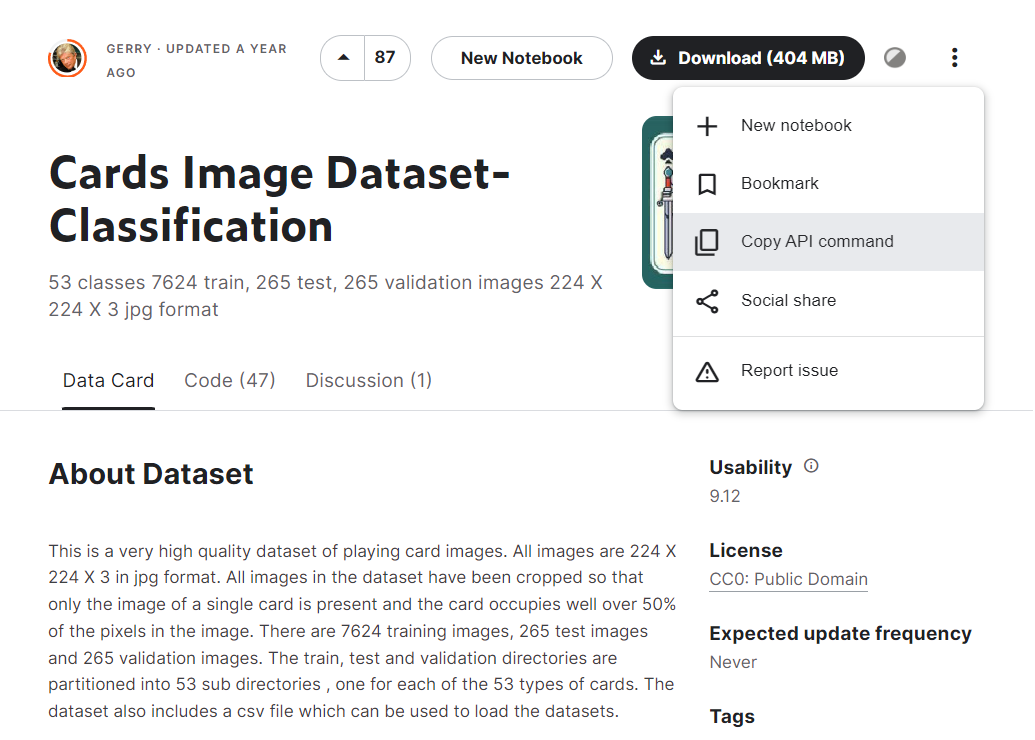

# Step 1. Pytorch Dataset (and Dataloader)

Create a custom dataset class that inherits from PyTorch's Dataset class:

In [6]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    @property
    def classes(self):
        return self.data.classes

## Transforming training dataset

In [7]:
dataset = PlayingCardDataset(data_dir="./input/train/")

6


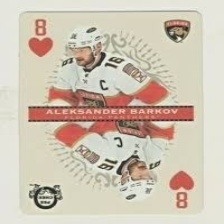

In [8]:
image, label = dataset[999]
print(label)
image

Get a dictionary associating target values with folder names:


In [9]:
data_dir = "./input/train/"
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [10]:
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

dataset = PlayingCardDataset(data_dir, transform)

Recreate the dataset with `transform`:

In [11]:
image, label = dataset[999]
print(label)
image.shape

6


torch.Size([3, 128, 128])

This next loop doesn't execute any specific functions or operations on the dataset elements. Its primary purpose is to check that the dataset is iterable, meaning it can be looped over without causing errors.   

This kind of loop is useful for quickly verifying that the dataset setup is correct, particularly that the __getitem__ method of the PlayingCardDataset class is functioning as intended. It's a simple test to ensure that at least the first item can be accessed and that the dataset behaves as expected in a loop structure.

In [12]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

In PyTorch, DataLoaders are used for efficiently loading and iterating over datasets. They handle the process of fetching data, potentially in parallel, and preparing it for training or inference in neural networks.  

DataLoaders are particularly useful for managing large datasets that cannot be loaded entirely into memory, offering functionality like batching, shuffling, and data transformation. They streamline the data pipeline, ensuring that data is readily available in the required format for each training step without manual handling, thus optimizing the computational efficiency of the model training process.

In [13]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
for images, labels in dataloader:
    break

`images.shape` now gives an additional dimension (32) - reflecting `batch_size`

In [15]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

labels are also now not in order, because the arg `shuffle=True` was provided.

In [16]:
labels

tensor([51, 50, 11, 18, 52, 43, 29, 51, 23, 44,  0, 47, 38, 15,  2, 16, 36, 24,
        47, 35, 19,  7, 51, 37, 30, 29, 14, 40, 32, 46, 49, 38])

# Step 2: PyTorch Model

In [17]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        self.base_model = timm.create_model("efficientnet_b3", pretrained=True)
        # remove classifier part of base model
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        # add Adaptive Pooling
        self.pool = nn.AdaptiveAvgPool2d(1)

        # output channels of last convolutional layer in efficientnet_b3
        enet_out_channels = self.base_model.num_features

        # define the classifier
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(enet_out_channels, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        output = self.classifier(x)
        return output

The CV model chosen here is `efficientnet_b3`. Against other models, it gives good performance relative to the small number of parameters it has. Related reading can be found [here](https://arxiv.org/abs/1905.11946v5).

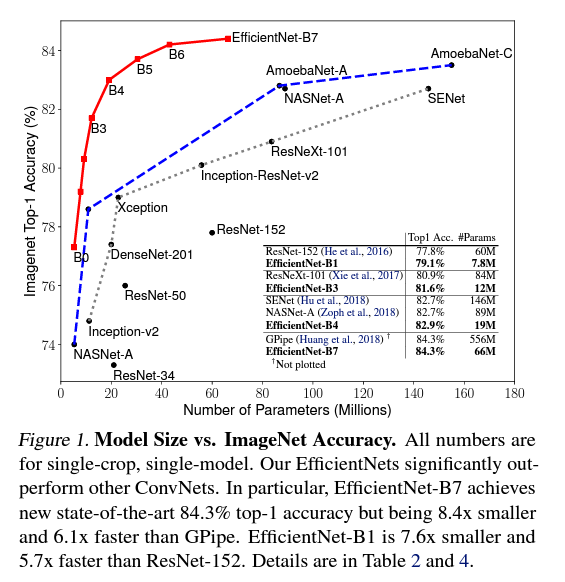

In [18]:
model = SimpleCardClassifer(num_classes=53)

Sneak peek at the model architecture:

In [19]:
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=Fal


Check if model's output is as expected by feeding it the images:

In [20]:
example_out = model(images)
example_out.shape  # get [batch_size, num_classes]

torch.Size([32, 53])

# Step 2.5: Setup datasets

In [21]:
train_folder = "./input/train/"
valid_folder = "./input/valid/"
test_folder = "./input/test/"

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Step 3: Training loop

Define loss function and optimizer to use:

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Simple test if code works up to this point:

In [23]:
criterion(example_out, labels)

tensor(4.0018, grad_fn=<NllLossBackward0>)

Check for CUDA compatibility:

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
num_epochs = 5
train_losses, val_losses = [], []

model = SimpleCardClassifer(num_classes=53)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training loop"):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation loop"):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(
        f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}"
    )

Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5847079241638544, Validation loss: 0.4568149787075115


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.45816932294951657, Validation loss: 0.21194699102977538


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.23028002105504744, Validation loss: 0.2388653759686452


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.1438410510499605, Validation loss: 0.23078365145989185


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.13294286649099551, Validation loss: 0.1595607431429737


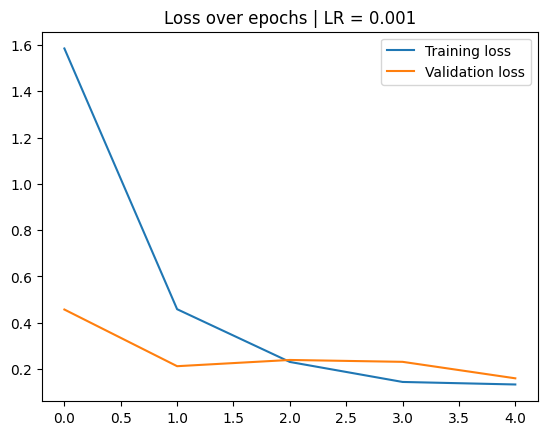

In [26]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Loss over epochs | LR = 0.001")
plt.show()

As expected, both training and validation loss decreases in the first few epochs, but that improvement tapers off quickly.  
Validation curve doesn't seem to indicate overfitting.  

## Try a higher LR

Would a higher learning rate lead to a lower validation loss in this instance?

In [27]:
train_losses_high_lr, val_losses_high_lr = [], []
model_high_lr = SimpleCardClassifer(num_classes=53)
model_high_lr.to(device)

optimizer = optim.Adam(model_high_lr.parameters(), lr=0.01)

for epoch in range(num_epochs):
    model_high_lr.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training loop"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_high_lr(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses_high_lr.append(train_loss)

    # Validation phase
    model_high_lr.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation loop"):
            images, labels = images.to(device), labels.to(device)

            outputs = model_high_lr(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses_high_lr.append(val_loss)
    print(
        f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}"
    )


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 2.4532518017829905, Validation loss: 1.3499259631588774


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 1.3009172639216355, Validation loss: 0.9255080564966741


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 1.0886504505013368, Validation loss: 0.675898995039598


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.8018533942081495, Validation loss: 0.4324081501870785


Training loop:   0%|          | 0/120 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.6630257887204821, Validation loss: 0.31507640154856553


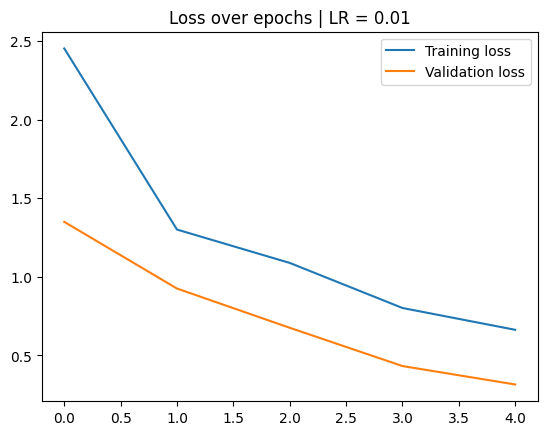

In [31]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Loss over epochs | LR = 0.01")
plt.show()


A LR of 0.01 was too high - resulting in worse performance.

# Model performance on test set

In [29]:
# test_losses = []
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(num_epochs):
#     # Test phase
#     model.eval()
#     running_loss = 0.0
#     with torch.no_grad():
#         for images, labels in tqdm(test_loader, desc="Validation loop"):
#             # Move inputs and labels to the device
#             images, labels = images.to(device), labels.to(device)

#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             running_loss += loss.item() * labels.size(0)
#     test_loss = running_loss / len(test_loader.dataset)
#     test_losses.append(test_loss)
#     print(f"Epoch {epoch+1}/{num_epochs} - Testing loss: {test_loss}")



In [30]:
# Testing phase
model.eval()  # Ensure the model is in evaluation mode
test_loss = 0.0
# Other metrics initialization, if necessary

with torch.no_grad():  # No gradient tracking needed
    for images, labels in tqdm(test_loader, desc="Testing loop"):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        # Compute other metrics, if necessary

# Calculate average loss over the test set
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")


Testing loop:   0%|          | 0/5 [00:00<?, ?it/s]

Test Loss: 0.27518063496868567
